In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# TODO: Images in the latent space plot, and then images on test (need to supply them as goals)

In [2]:
import argparse


parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')

args = parser.parse_args('''
PROB0_001
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-d GPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
-n 5


'''.split())
path = f"saved_models/{args.run_name}"    

In [3]:
# -tfr
# -i


In [4]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random
from natsort import natsorted
import lfp
import importlib
arm = 'UR5'

TEST_DATASET = "UR5_slow_gripper_test" 
print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)


Using local setup
Working path: /home/sholto/Desktop/AI/learning_from_play
Storage path: /home/sholto/Desktop/AI/learning_from_play


In [5]:
physical_devices = tf.config.list_physical_devices(args.device)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:

#args.run_name = "GCSB0_00003" #"PROB0_02"
             #ALLB0.00003_60k"

In [7]:

# hyper_params = np.load(f'{path}/hyper_params.npz', allow_pickle=True)
# scaling = hyper_params['scaling']
# for k,v in hyper_params.items():
#     print(k,v)
if args.images:
    GLOBAL_BATCH_SIZE = 16
    shuffle_size = GLOBAL_BATCH_SIZE*5
else:
    GLOBAL_BATCH_SIZE = 512
    shuffle_size = None # allow the dl to set it

dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=GLOBAL_BATCH_SIZE, shuffle_size = shuffle_size)

In [8]:
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 85.50it/s]


{   'acts': TensorSpec(shape=(512, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(512, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(512, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(512, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(512, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(512,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(512, None, 1), dtype=tf.int32, name=None)}


In [9]:
print(f'Obs: (N,{dl.obs_dim}), Acts: (N,{dl.act_dim}), Goals: (N,{dl.goal_dim})')

Obs: (N,18), Acts: (N,7), Goals: (N,11)


# Load our  models

In [10]:
model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
            'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
            'act_dim':dl.act_dim,
            'layer_size':args.actor_layer_size, 
            'latent_dim':args.latent_dim}

actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)

if args.gcbc:
    encoder = None
    planner = None
else:
    model_params['layer_size'] = args.encoder_layer_size
    encoder = lfp.model.create_encoder(**model_params)
    model_params['layer_size'] = args.planner_layer_size
    planner = lfp.model.create_planner(**model_params)
    
if args.images:
    cnn = lfp.model.cnn(dl.img_size, dl.img_size, embedding_size=args.img_embedding_size)
    lfp.utils.build_cnn(cnn) # Have to do this becasue it is subclassed and the reshapes in the spatial softmax don't play nice with model auto build
else:
    cnn = None

In [12]:
lfp.utils.load_weights(path,actor, encoder, planner, cnn)

Checkpoint restored


In [13]:
v_it = iter(valid_dataset)
batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
T = states.shape[1]
if args.images:
    imgs, proprioceptive_features, goal_imgs = batch['imgs'], batch['proprioceptive_features'], batch['goal_imgs']
    states, goals = lfp.utils.images_to_2D_features(imgs, proprioceptive_features, goal_imgs, cnn)
    
if args.gcbc:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) 
                                                  
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, T, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, T, 1))
  pred_acts = actor([states, z, goals]) 

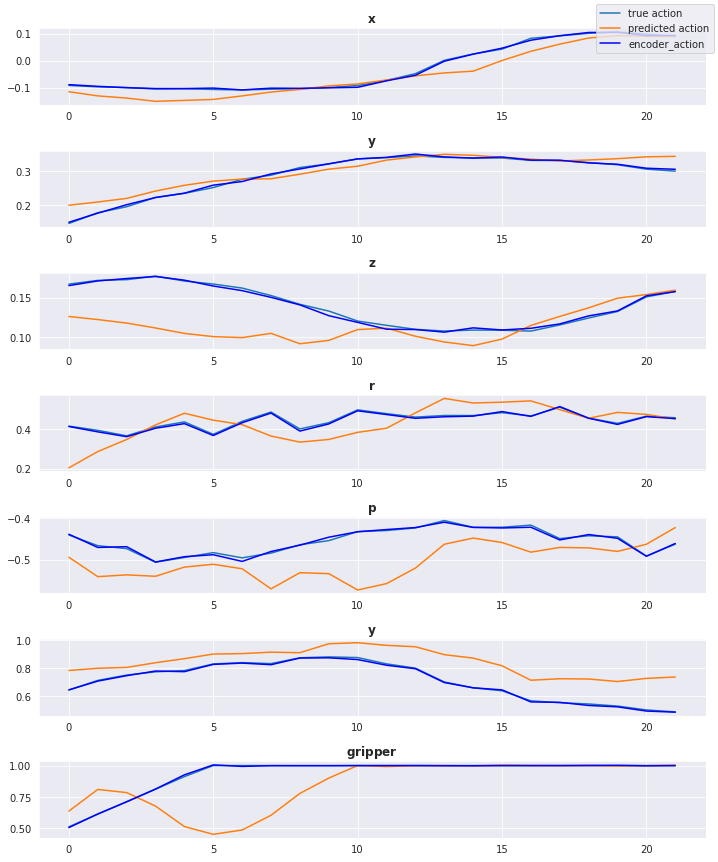

In [14]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 4
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','r','p','y','gripper']
fig, axes = plt.subplots(dl.act_dim, 1, figsize=(10,12), squeeze=True)
for i in range(dl.act_dim):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not args.gcbc:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

In [15]:

batch = iter(valid_dataset).next()

In [16]:

import importlib

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


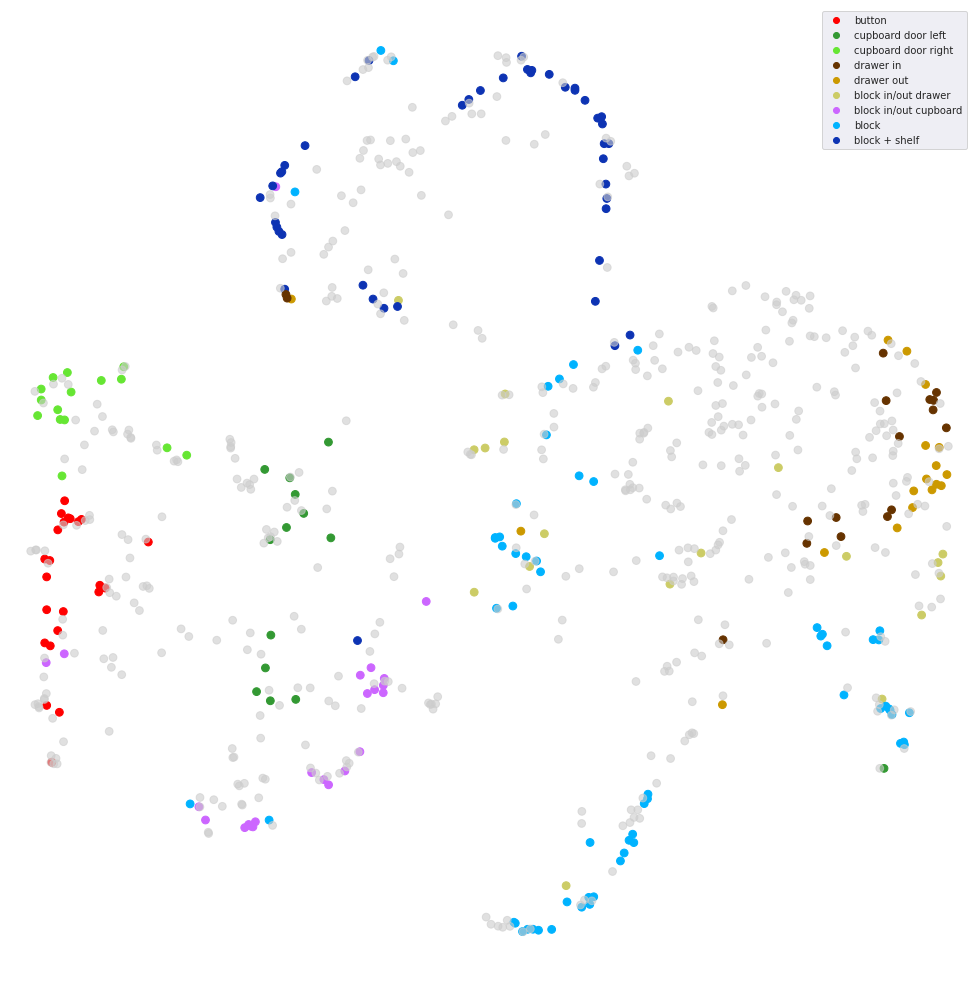

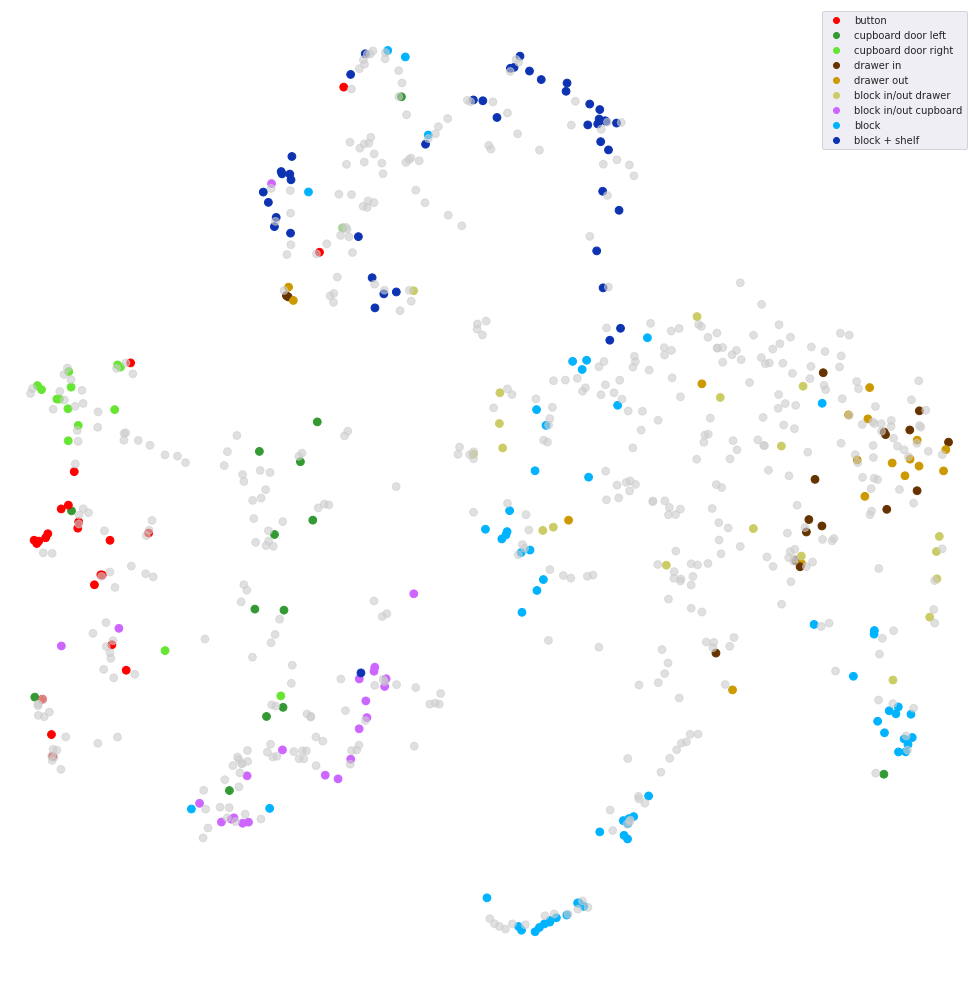

In [17]:
from lfp.plotting import produce_cluster_fig
%matplotlib inline
fig_enc_, fig_plan__ = produce_cluster_fig(batch, encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size, args=args, cnn=cnn)

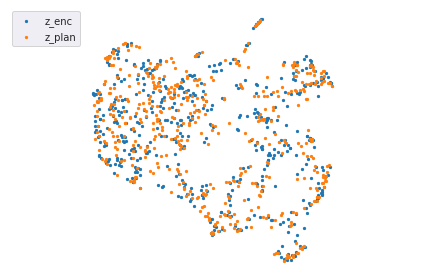

In [18]:
from lfp.plotting import project_enc_and_plan

o = project_enc_and_plan(encoding.sample(), plan.sample(), connecting_lines=False)

In [30]:
env.panda.close()


closing


In [45]:

import time
import seaborn as sns


env = lfp.utils.load_env(JOINTS = dl.joints, QUAT = dl.quaternion_act, RELATIVE = dl.relative_act)
env.render('human')
env.reset()
if args.images:
    env.render('playback')

/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN',

/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


In [17]:


model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
            'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
            'act_dim':dl.act_dim,
            'layer_size':args.actor_layer_size, 
            'latent_dim':args.latent_dim,
            'training':False, 'return_state':True}

actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)

lfp.utils.load_weights(path, actor, encoder, planner, cnn)

Checkpoint restored


In [18]:
lfp.utils.load_weights(path, actor, encoder, planner, cnn)

Checkpoint restored


# Test against specified goals

In [56]:
def flatten_obs(obs_dict, record_o_buff=None):
    '''
    Get the right format and flatten, e.g get joints states, velcoities, rpy or quat etc depending on what the
    net was trained on
    Also appends it to record_o_buff to record the true obs
    '''

    o = obs_dict['observation']
    
    if args.images:
        proprioceptive_features = tf.cast(tf.expand_dims(o[:7],0), tf.float32)
        img = obs_dict['img']
        img_embedding = cnn(tf.expand_dims(img, 0))
        o = tf.squeeze(tf.concat([img_embedding, proprioceptive_features],axis=1))
        
    if dl.joints:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([o, obs_dict['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(o,0),0)
        
    if dl.gripper_proprioception:
         o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast([obs_dict['gripper_gripper_proprioception']],tf.float32),0),0)], axis = -1)
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    if record_o_buff is not None:
        record_o_buff.append(o)
    return o


def choose_action(actor, o, z, goal, states=None, a_pred=None, a_true=None, replay=False, i = -0):
    if args.gcbc:
        a,_,state = actor((o, goal))
    else:
        a,_,state = actor((o, z,goal))
        
    if args.num_distribs is not None:
        a = a.sample().numpy().squeeze()
    else:
        a = a.numpy().squeeze()
    if states is not None:
        states.append(state)
    if a_pred is not None:
        a_pred.append(a)

    if replay: # the less than is just so we can set it so the first n are from demonstration- to check if the init is the issue
        a=a_true[i, :] 
    return a

def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None, reset_goal=True):
    
    a_pred = []
    states = []
    record_o_buff = []
    plans = [] 
    
    state = env.panda.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    
    for j in range(0,retries):
        
        
        
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter
            if j<=1 or reset_goal: # if its the first/two (solves some weird shit in the env with the button bouncing around) time or we reset the goal to ignore pertubations of other objects
                g = goal['func'](*goal['args'])
                env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if args.gcbc:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
            plans.append(z.numpy())
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len
            
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if not args.images:
                if success_func(g, ag):
                    success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans, success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans,  success

In [54]:
from lfp.tests import tester, tasks, success_func, tests

tester = tester(env)

kwargs = {'goal':{'func':tester.make_goal, 'args':None}, 'retries':20, 'replan_horizon':10, 'end_on_success':True, 'record_dir': None, 'reset_goal':False}

In [ ]:
test_results = []

In [ ]:
from lfp.configs_to_test import B0003, B00003,B000003, PB02
import pandas as pd
test_names = ['dial_off']
 
    
test_names = ['door_left','button','door_right','open_drawer','close_drawer','dial_off',\
              'block_cupboard_right','block_cupboard_left','block_left',\
              'block_right','block_shelf','block_drawer',\
            'block_lengthways', 'block_ori_default','block_upright'] 
 
 
configs_to_test = [PB02, B000003]

for config in configs_to_test:
    
    args = parser.parse_args(config)
    path = f"saved_models/{args.run_name}"    
    model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
            'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
            'act_dim':dl.act_dim,
            'layer_size':args.actor_layer_size, 
            'latent_dim':args.latent_dim,
            'training':False, 'return_state':True}

    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)
    lfp.utils.load_weights(path, actor, encoder, planner, cnn)
    print(f"Loaded {args.run_name}")
    
    run_results = {'name': "R"+args.run_name}
    for i, test in enumerate(test_names):
        successes = []
        for j in range(0,30):
            _ = env.reset()
            tester.prepare_env(test)
            kwargs['goal']['args'] = tests[test]
            _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)
            successes.append(succeeded)
        print(f"{test} success rate -  {np.mean(successes)}")
        run_results[test] = np.mean(successes)
    test_results.append(run_results)
        

Checkpoint restored
Loaded PROB0_02
door_left success rate -  0.9333333333333333
button success rate -  0.9
door_right success rate -  0.9333333333333333
open_drawer success rate -  0.9666666666666667
close_drawer success rate -  0.9333333333333333
dial_off success rate -  1.0
block_cupboard_right success rate -  0.7
block_cupboard_left success rate -  0.5
block_left success rate -  0.8
block_right success rate -  0.7666666666666667
block_shelf success rate -  0.9666666666666667
block_drawer success rate -  0.3333333333333333


In [ ]:

pd.DataFrame(test_results).to_pickle(os.getcwd()+'/experimental/Test_logs2.pkl')

In [58]:

#env.panda.close()
pd.DataFrame(test_results)

,block_cupboard_left,block_cupboard_right,block_drawer,block_left,block_lengthways,block_ori_default,block_right,block_shelf,block_upright,button,close_drawer,dial_off,door_left,door_right,name,open_drawer
0,0.6,0.633333,0.333333,0.566667,0.300000,0.966667,0.500000,0.766667,0.566667,0.433333,0.966667,0.900000,0.700000,0.866667,GCSB0_0003,0.866667
1,0.7,0.600000,0.600000,0.733333,0.466667,0.833333,0.766667,0.700000,0.533333,1.000000,0.933333,0.966667,0.800000,0.900000,GCSB0_00003,0.900000
2,0.6,0.833333,0.333333,0.900000,0.166667,0.866667,0.666667,0.700000,0.333333,1.000000,1.000000,1.000000,0.966667,0.833333,PROB0_02,1.000000
3,0.4,0.333333,0.133333,0.366667,0.466667,0.633333,0.266667,0.533333,0.066667,0.633333,1.000000,0.833333,0.866667,0.800000,GCSB0_000003,0.933333
4,0.6,0.466667,0.566667,0.866667,0.133333,0.900000,0.666667,0.900000,0.500000,0.966667,0.866667,0.966667,0.766667,1.000000,RGCSB0_00003,0.966667
5,0.6,0.566667,0.200000,0.700000,0.166667,0.633333,0.566667,0.833333,0.500000,0.433333,0.833333,0.933333,0.600000,0.766667,RGCSB0_0003,0.900000


In [48]:


task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_lengthways_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

In [80]:
import importlib
importlib.reload(lfp.tests)

<module 'lfp.tests' from '/home/sholto/Desktop/AI/learning_from_play/lfp/tests.py'>

# Test against goals from the test data examples

In [48]:
import time

from lfp.plotting import get_labelled_trajs

def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(str(TEST_DIR/'states_and_ims'/str(f)/'env_states/*.bullet'))
    print(potential_start_points)
    if config.OS == 'windows':
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATHS[0])}/states_and_ims/{str(f)}/env_states\\", "")) for x in potential_start_points]
    else:
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATHS[0])}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
        
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts_quat'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs_quat'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                


def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_TEST_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(TEST_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.panda.calc_state()
    #print(state['achieved_goal'] - goal)
    #print(goal.shape, a_true.shape, o_true.shape, traj_len)
    return goal, a_true, o_true, traj_len, state


def test_random_subseq(data, idx, retries = 1, replay=False, replan_horizon=30):
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    a_true, a_pred, states, o_true, record_o_buff, _ = rollout_subseq(goal, retries , replan_horizon, a_true, o_true, traj_len, replay)
    return a_true, a_pred, states, o_true, record_o_buff


##############################################################################
def get_x_of_seq_type(lbl, n = 'all'):
    o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features = get_labelled_trajs(TEST_DATA_PATHS[0], args=args)
    idxs = [ i for i,x in enumerate(labels) if x == lbl]
    print(f"There are {len(idxs)} examples of '{lbl}'")
    if n == 'all':
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, idxs
    elif n == 'random':
        idx = np.random.choice(idxs)
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, [idx]
    else:
        idx = idxs[n]
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, [idx]

def initialise_seq_type(g, paths, idx):

    try:
        env.delete_sub_goal()
    except:
        pass
    print(paths[idx])
    env.p.restoreState(fileName=str(paths[idx]))
    if args.images:
        goal  =  tf.expand_dims(cnn(tf.expand_dims(g[idx], 0)),0)
        print(goal.shape)
    else:
        env.visualise_sub_goal(g[idx], 'achieved_goal') # if we're using images, don't viz the goal as this will change things
        goal = tf.expand_dims(tf.expand_dims(g[idx], 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    

    return goal

def test_seq_type(data, retries = 1, replay=False, replan_horizon=30):
    o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, idxs = data
    successes = []
    for idx in idxs:
        if args.images:
            g = goal_imgs
        goal = initialise_seq_type(g, paths, idx)
        a_true, o_true, traj_len = a[idx], o[idx], len(a[idx])
        a_true, a_pred, states, o_true, record_o_buff, plans, success = rollout_subseq(goal, retries, replan_horizon, a_true, o_true, traj_len,replay)
        successes.append(success)
        
    return successes 




#########################################

    
    

In [55]:
lbl = 'lift up'
data = get_x_of_seq_type(lbl, n = 'all') # all, random or n

There are 28 examples of 'lift up'


In [51]:
successes = test_seq_type(data, retries = 1, replay=True, replan_horizon=30)

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/420.bullet
(1, 1, 64)
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5760.bullet
(1, 1, 64)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sholto/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-9f43304614e1>", line 1, in <module>
    successes = test_seq_type(data, retries = 1, replay=True, replan_horizon=30)
  File "<ipython-input-48-38c2e099c685>", line 152, in test_seq_type
    a_true, a_pred, states, o_true, record_o_buff, plans, success = rollout_subseq(goal, retries, replan_horizon, a_true, o_true, traj_len,replay)
  File "<ipython-input-50-96a6f0869b73>", line 85, in rollout_subseq
    o, r, d, _ = env.step(a)
  File "/home/sholto/Desktop/AI/pandaRL/pandaRL/envs/environments.py", line 1168, in step
    obs = self.panda.calc_state()
  File "/home/sholto/Desktop/AI/pandaRL/pandaRL/envs/environments.py", line 640, in calc_state
    renderer=self.bullet_client.ER_BULLET_HARDWARE_OPENGL)[2][:,:,:3] #just the rgb
KeyboardInterrupt

During handling

KeyboardInterrupt: 

In [56]:
successes = test_seq_type(data, retries = 10, replay=False, replan_horizon=10)

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4050.bullet
(1, 1, 64)
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3120.bullet
(1, 1, 64)
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/6240.bullet
(1, 1, 64)


KeyboardInterrupt: 

# Make recordings, and replay them while visualising the plans chosen

In [54]:
record_path = os.getcwd() + '/recordings/'

def make_recording_dir():
    demo_count = len(list(os.listdir(record_path)))
    example_path = record_path + str(demo_count)
    os.makedirs(example_path)
    return example_path


def record_state(path):
    t_step = len(list(os.listdir(path)))
    env.p.saveBullet(path +'/'+ str(t_step)) 

In [30]:

#env.render('playback') # 10 is good

In [73]:
import shutil
record_path = os.getcwd() + '/recordings/'

while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    path = make_recording_dir()
    successes = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        _,a_pred,_,_,_,succeeded  = rollout_subseq(**kwargs)
        predicted_actions.append(a_pred)
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        print(successes)
        if successes <= 10:
            shutil.rmtree(path)
    except:
        pass
    


8
4
11
5
4
11
11
11
6
4
6
2
7
4
9
11
2
6
2
6
11
11
12
12
10
5
11
7
4
7
8
6
4
11
5
12
12
11
7
6
11
9
11
11
6
12
9
4
6
6
4
4
6
6
0
7
0
11
11
11
3
2
8
11
7
11
12
4
11


KeyboardInterrupt: 

In [56]:

#fig_plan, scatter = project_labelled_latents(reducer, z_plan.sample(), colors + batch_colors, True)
batch = iter(valid_dataset).next()

In [68]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)
from lfp.plotting import bucket_colors, get_labelled_trajs, hold_out
def establish_background(path):
    batch_size=dl.batch_size
    obs, acts, goals, labels, colors, paths, imgs, goal_imgs, proprioceptive_features = get_labelled_trajs(TEST_DATA_PATHS[0], bucket=True)
    batch_states,batch_acts, batch_goals, batch_colors = batch['obs'][:batch_size, :40, :],batch['acts'][:batch_size, :40, :], batch['goals'][:batch_size, 0, :], [[0.8,0.8,0.8,0.6]]*batch_size
    obs  = np.concatenate([obs, batch_states])
    acts = np.concatenate([acts, batch_acts])
    goals = np.concatenate([goals, batch_goals])
    initial_state = obs[:, 0, :]
    z_enc = encoder((obs,acts)).sample()
    z_plan = planner((initial_state, goals))
    sampled_plans = np.load(path+'/sampled_plans.npy')
    background = z_plan.sample()

    z_space = np.concatenate([z_enc, background, sampled_plans])
    reducer.fit(z_space)
    z_space = z_space[len(z_enc):] # Just put the encoded ones in there for additional structure in UMAP's fit
    
    # Make the colors
    combined_colors = colors+batch_colors
    
    z_embed = reducer.transform(z_space)
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(z_embed[:len(background), 0], z_embed[:len(background), 1], s=60, label='z', c = combined_colors)
    ax.set_aspect('equal', 'datalim')
    ax.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout()


    colors_dict = bucket_colors.copy()
    for i in hold_out:
        del colors_dict[i]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_dict.values()]
    plt.legend(markers, colors_dict.keys(), numpoints=1)
    
    return fig, ax, z_embed[:len(colors)], colors, z_embed[len(background):]

from scipy.spatial import KDTree

def plot_plan(i, z_embed, past_point=None):
    tree = KDTree(z_labelled)
    plan = z_embed[int(i//replan_interval)]
    dd, ii = tree.query(plan, k=1) # get the nns
    spot_color = np.array(label_colors)[ii]# np.mean(np.array(label_colors)[ii], axis=0)
    if pp is not None:
        pp.remove()
    scatter = ax.scatter(z_embed[int(i//replan_interval), 0], z_embed[int(i//replan_interval), 1], s=400, color = spot_color)
    plt.pause(0.01)
    
    return scatter

In [100]:
# This is replaying to visualise the plot 
%matplotlib qt

path = '/home/sholto/Desktop/AI/learning_from_play/recordings//13'
fig, ax, z_labelled, label_colors, z_proposed = establish_background(path)
pp = None

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [104]:

states = natsorted(list(os.listdir(path)))
states = [path+'/'+x for x in states if 'npy' not in x]
acts = np.load(path+'/predicted_actions.npy')
intervals = np.load(path+'/indices.npy')
replan_interval = len(states)/len(z_proposed)


time.sleep(1.0)
for i,s in enumerate(states):
        if i % replan_interval == 0:
             pp = plot_plan(i, z_proposed, pp)
        env.p.restoreState(fileName = s)
        env.step(acts[i])
        
        
        env.panda.updateToggles()

In [70]:
def replay_recording(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    acts = np.load(path+'/predicted_actions.npy')
    intervals = np.load(path+'/indices.npy')
    for i,s in enumerate(states):
#         if int(i.split('/')[-1]) > 100:
#             print(i.split('/')[-1])
            env.step(acts[i])
            env.p.restoreState(fileName = s)
            env.panda.updateToggles()
            
            


In [108]:
path = '/home/sholto/Desktop/AI/learning_from_play/recordings//2'


(61, 256)

In [103]:

replay_recording('/home/sholto/Desktop/AI/learning_from_play/recordings//2')


In [166]:
def random_point():
    x = np.random.choice([0.5, -0.5])
    y =  np.random.choice([0.5, -0.5])
    z =  np.random.choice([0.3, 0.5, 0.6])
    return [x, y, z]
def create_adversary():
    
    side = 0.03
    colcubeId = bullet_client.createCollisionShape(bullet_client.GEOM_BOX, halfExtents=[side, side, side])
    visplaneId = bullet_client.createVisualShape(bullet_client.GEOM_BOX, halfExtents=[side, side, side],
                                                 rgbaColor=[1, 1, 1, 1])
    
    block = bullet_client.createMultiBody(0.1, colcubeId, visplaneId,random_point())
    return block

def guide_adversary(block):
    x1 = np.array(bullet_client.getBasePositionAndOrientation(block)[0])
    x2 = np.array(env.panda.calc_state()['observation'][0:3])
    bullet_client.applyExternalForce(block, -1, (x2-x1)*100, [0,0,0], bullet_client.LINK_FRAME)
    #bullet_client.stepSimulation()
    
bullet_client = env.p
adversaries = []
def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None):
    
    a_pred = []
    states = []
    record_o_buff = []
    plans = [] 
    
    state = env.panda.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    for b in adversaries:
        bullet_client.removeBody(b)
    for j in range(0,retries):
        
        
        
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter
            g = goal['func'](*goal['args'])
            env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if args.gcbc:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
            plans.append(z.numpy())
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len
            
        
        block = create_adversary()
        adversaries.append(block)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            
            guide_adversary(block)
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if success_func(g, ag):
                success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans, success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans,  success